<a href="https://colab.research.google.com/github/atahanoezer/Wind/blob/main/UEBB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
!pip install catboost

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
! git clone https://github.com/atahanoezer/Wind.git

Cloning into 'Wind'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 199 (delta 80), reused 136 (delta 38), pack-reused 0
Receiving objects: 100% (199/199), 17.90 MiB | 6.23 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [6]:
from Wind.dataset import Dataset
from Wind.utils import score_function
from Wind.model import *

In [7]:
import warnings
warnings.filterwarnings('ignore') # to avoid catboost and pd warnings

# Data Preprocess

In [8]:
uebb = '/content/drive/MyDrive/Copy of UEBB_v1.nc'
ds = xr.open_dataset(uebb)
df = ds.to_dataframe()
df =df.loc[(df.index.get_level_values('Turbine') == 1.0) & (df.index.get_level_values('Height') == 60.0)]
df = df.reset_index()
df['Time']=pd.to_datetime(df['Time'])
df = df.set_index('Time')

In [9]:
test_time = pd.to_datetime('2014-05-18 18:50:00')
df_test = df[df.index >= test_time]
test_split = len(df_test)/len(df)

Following fields are observed via pandas profiling, reports can be generated by running the profiler function in utils.py

In [10]:
high_empty_fields = ['wind_direction_std','air_temperature','relative_humidity', 'UST','UST_flag', 'HS','HS_flag', 'TKE',
                     'LMO','ws_w_corrected'] #
missing_fields = ['wind_speed','wind_direction','wind_speed_std','wind_speed_max','wind_speed_min',
                         'wind_speed_cube','air_pressure','logger_temperature', 'battery_V','ws_u','ws_v','ws_w',
                         'tilt_X','tilt_Y','tilt_X_std','tilt_Y_std','wind_speed_nacelle','wind_speed_nacelle_max',
                         'wind_speed_nacelle_min','rotor_rpm','rotor_rpm_max','rotor_rpm_min','active_power_total',
                         'active_power_total_max','active_power_total_min','act_position','air_density']

In [11]:
roll_window = 4
dataset = Dataset(df)
dataset.fill_nan(missing_fields)
dataset.drop_nan(high_empty_fields)
dataset.add_seasonal_feat(dataset.df, dataset.df.index)
dataset.apply_rolling_window(dataset.df,'wind_speed', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'air_pressure', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'rotor_rpm', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'wind_speed_nacelle', roll_window,np.mean)

# Modelling



## Next Step



In [12]:
window = 48
horizon =1
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split = test_split,univariate = False)

In [13]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y, val_x, val_y)

Learning rate set to 0.090085
0:	learn: 206.2085286	test: 266.4783924	best: 266.4783924 (0)	total: 30.5ms	remaining: 30.5s
500:	learn: 45.2919208	test: 42.6008920	best: 42.6008920 (500)	total: 10.8s	remaining: 10.8s
999:	learn: 42.9080113	test: 42.4022692	best: 42.4022692 (999)	total: 21.2s	remaining: 0us
bestTest = 42.40226922
bestIteration = 999


                  MAE       RMSE        R2
Validation  24.951559  42.402264  0.914997
Test        35.263836  54.025818  0.934019


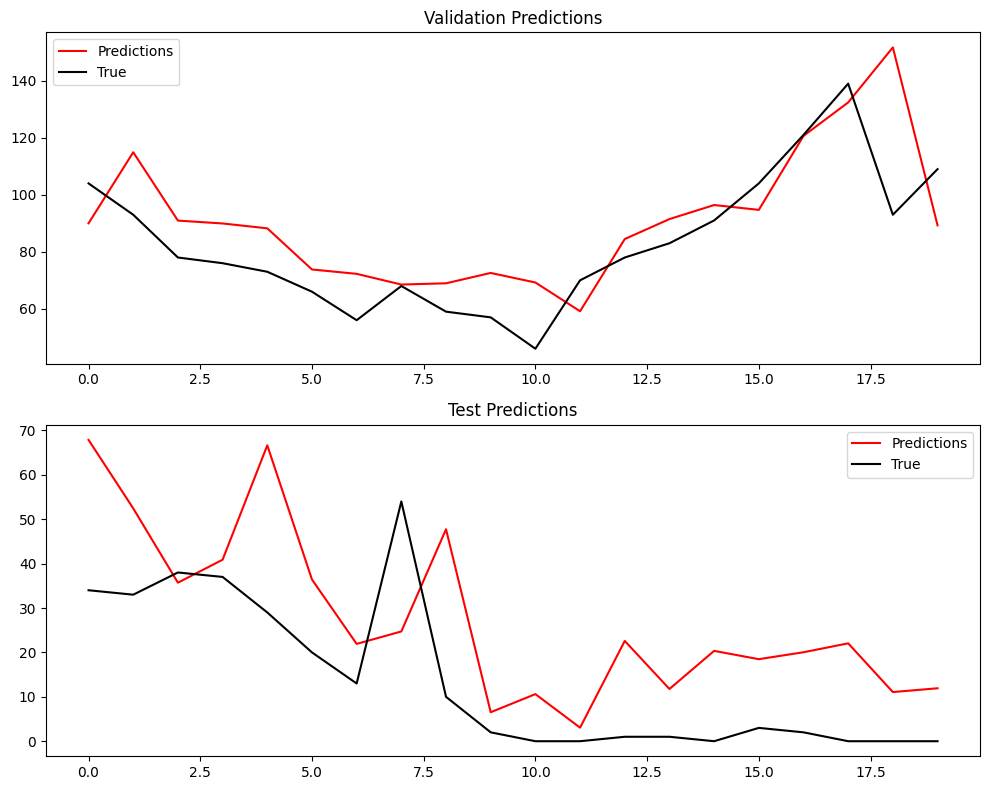

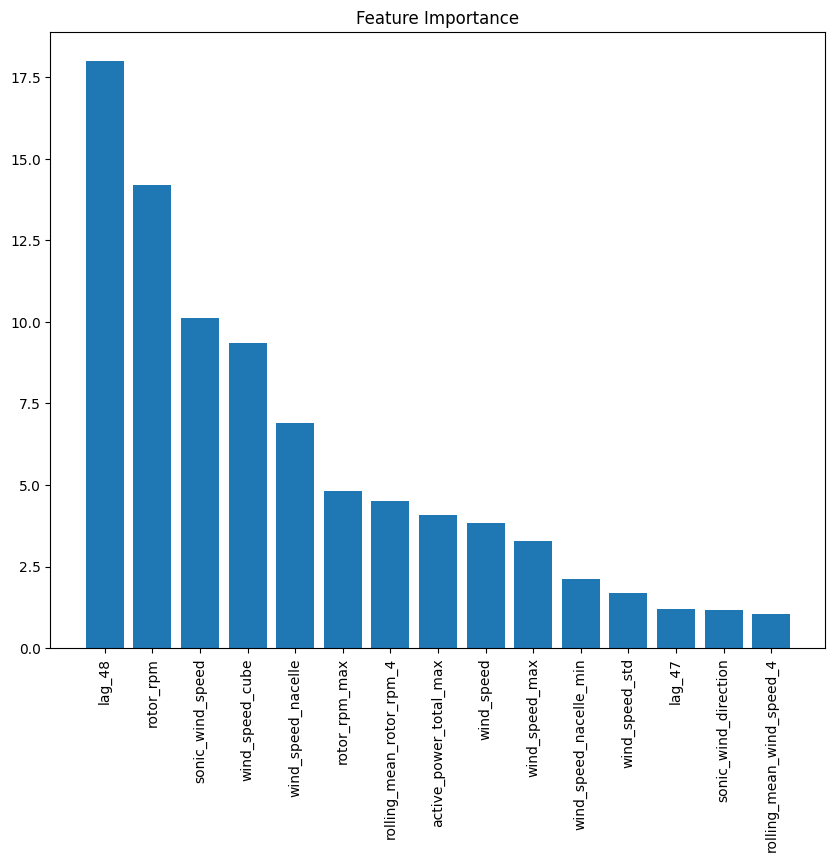

In [14]:
next_step_os,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=20, feat_importance=True, feat_steps=15,feat_names=columns)



## Next Hour One Shot



In [15]:
window = 48
horizon = 6
train_x,val_x, test_x, train_y,val_y, test_y, columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split = test_split)

In [16]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.090083
0:	learn: 210.2110081	test: 271.9176111	best: 271.9176111 (0)	total: 39.1ms	remaining: 39s
500:	learn: 85.1538533	test: 86.0650638	best: 84.4938643 (338)	total: 9.68s	remaining: 9.64s
999:	learn: 78.0575441	test: 90.3868614	best: 84.4938643 (338)	total: 20.5s	remaining: 0us
bestTest = 84.49386425
bestIteration = 338
Shrink model to first 339 iterations.


                  MAE        RMSE        R2
Validation  59.835040   84.493866  0.662592
Test        76.939254  108.670249  0.733016


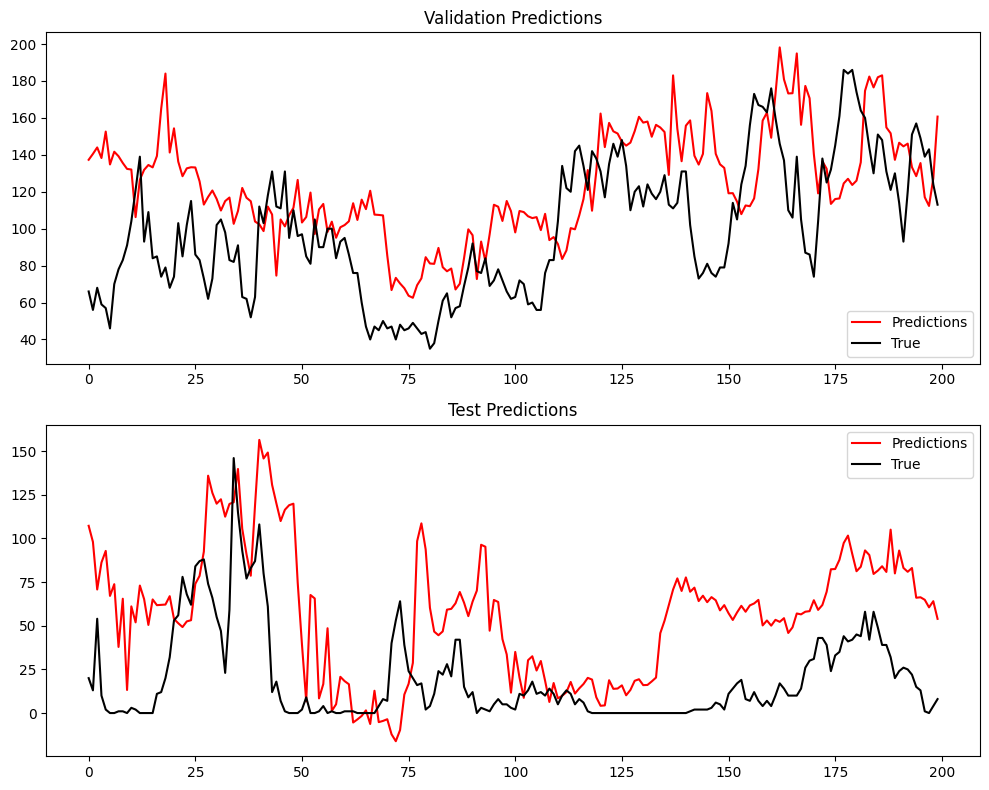

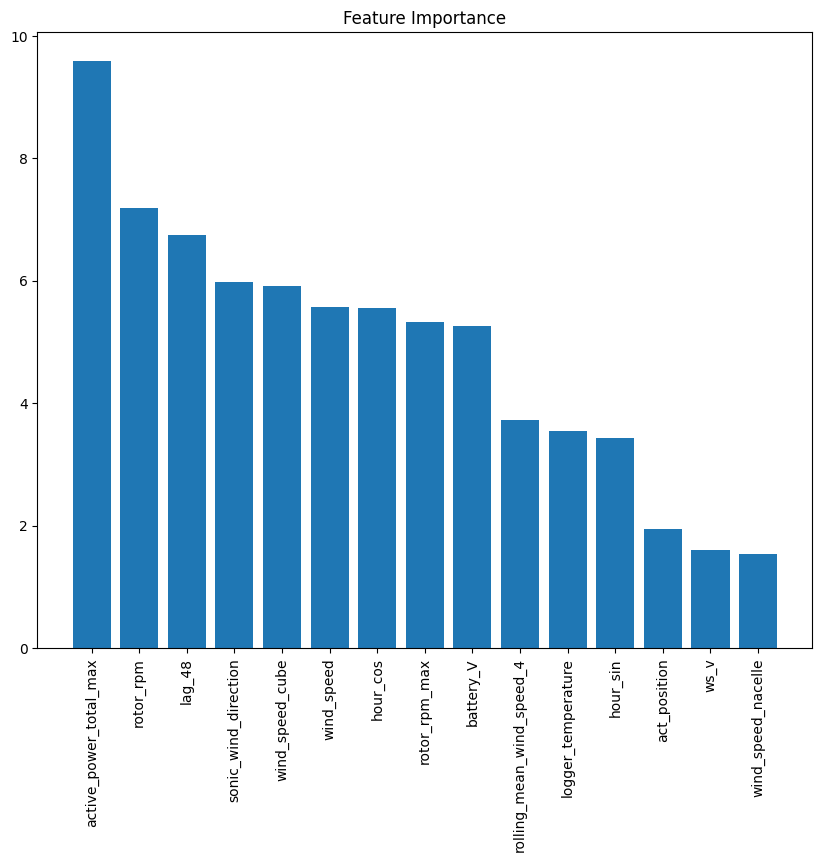

In [17]:
next_hour_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=True, feat_steps=15,feat_names= columns)

## Next Hour Recursive

In [18]:
window = 48
horizon = 6
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split = test_split,univariate= True)

In [19]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0],multioutput=False)

Learning rate set to 0.090083
0:	learn: 206.1987639	test: 265.5209396	best: 265.5209396 (0)	total: 31.7ms	remaining: 31.7s
500:	learn: 54.7908576	test: 46.2872279	best: 46.2639071 (248)	total: 9.18s	remaining: 9.14s
999:	learn: 52.6309837	test: 46.2304447	best: 46.2286804 (961)	total: 15.4s	remaining: 0us
bestTest = 46.2286804
bestIteration = 961
Shrink model to first 962 iterations.


                  MAE       RMSE        R2
Validation  41.163078  60.454525  0.827237
Test        54.669740  76.570211  0.867453


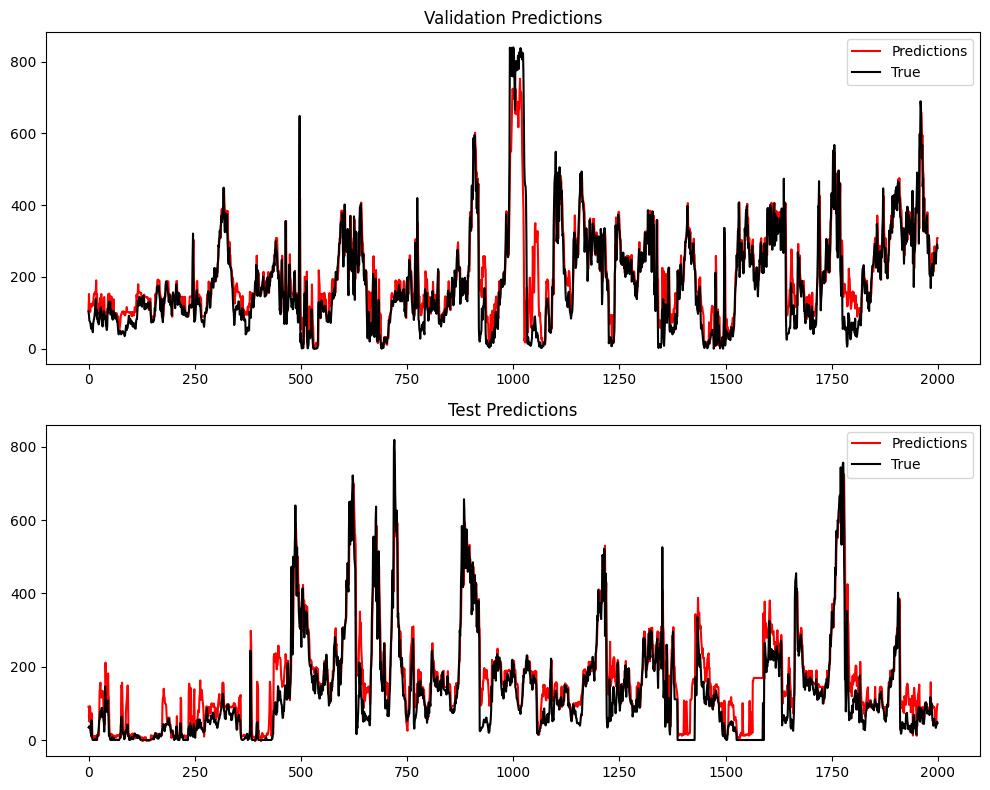

In [20]:
next_hour_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=2000, feat_importance=False, feat_steps=15,feat_names= columns,horizon =6)



## Next Day One Shot



In [21]:
window = 144
horizon = 144
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split= test_split)

In [22]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1], multioutput= False)

Learning rate set to 0.09001
0:	learn: 216.1312787	test: 277.5094448	best: 277.5094448 (0)	total: 53ms	remaining: 53s
500:	learn: 103.8620837	test: 166.1803646	best: 162.3941334 (262)	total: 16.1s	remaining: 16.1s
999:	learn: 86.3432129	test: 168.7214028	best: 162.3941334 (262)	total: 31.5s	remaining: 0us
bestTest = 162.3941334
bestIteration = 262
Shrink model to first 263 iterations.


                   MAE        RMSE        R2
Validation  133.983620  162.394121 -0.234556
Test        173.844097  207.840245  0.017956


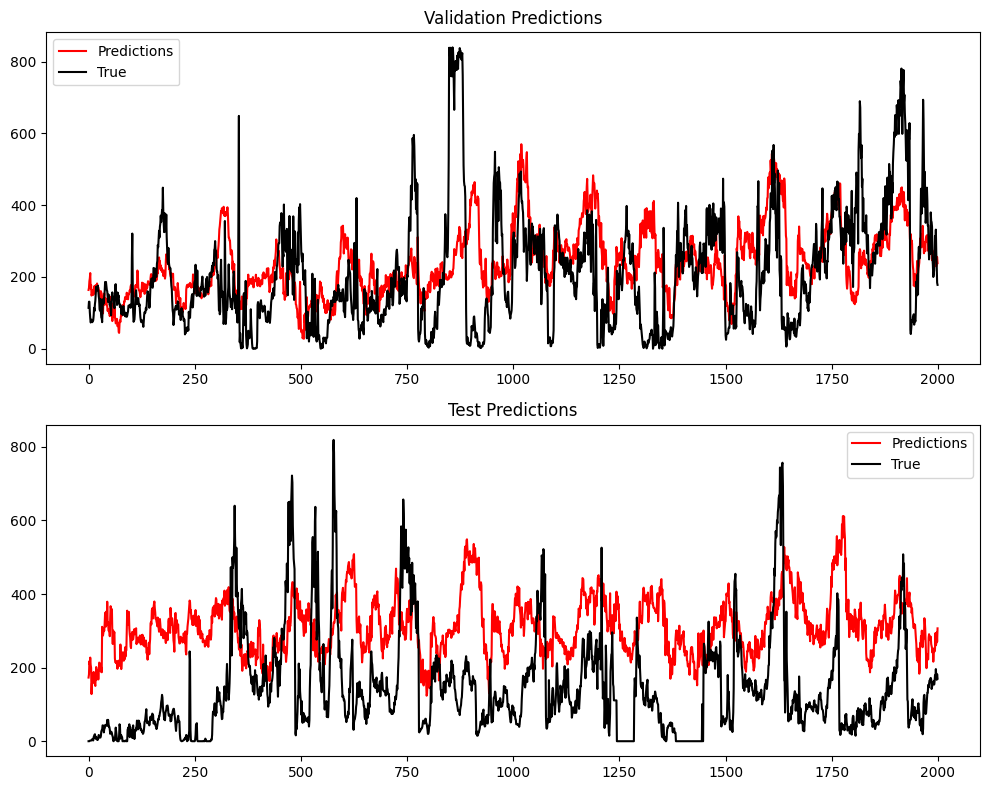

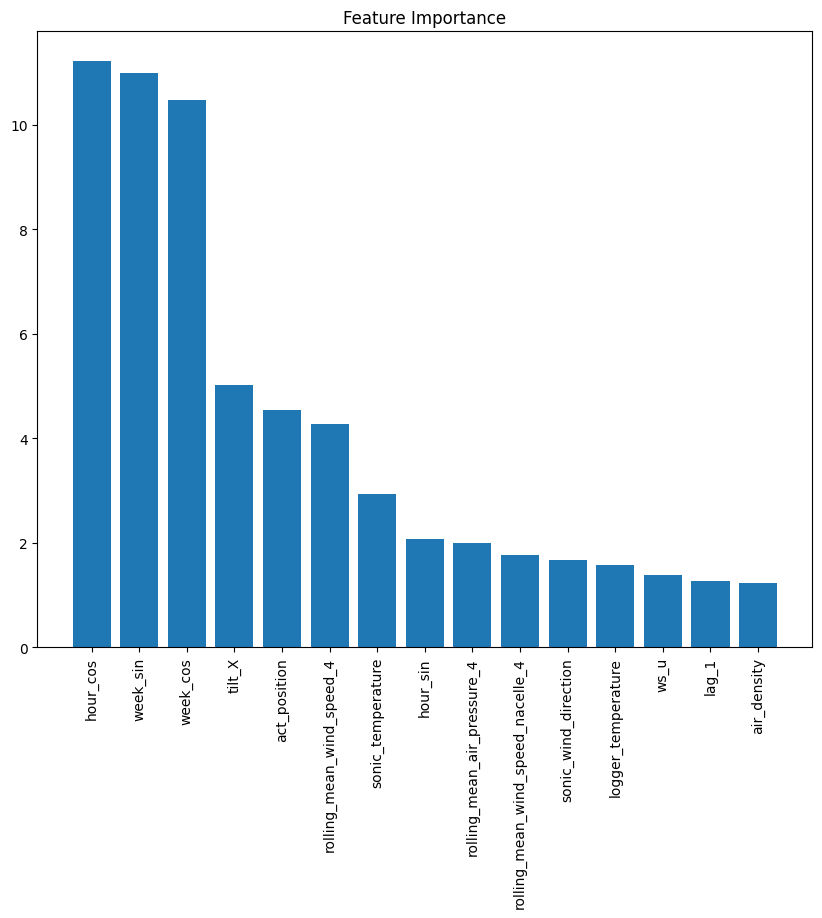

In [23]:
next_day_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=2000, feat_importance=True, feat_steps=15,feat_names= columns)

## Next Day Recursive

In [24]:
window = 144
horizon = 144
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split= test_split,univariate=True)

In [25]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0], multioutput= False)

Learning rate set to 0.09001
0:	learn: 206.3993047	test: 265.1672003	best: 265.1672003 (0)	total: 34.7ms	remaining: 34.7s
500:	learn: 54.0513369	test: 46.3728947	best: 46.3661623 (497)	total: 11.4s	remaining: 11.4s
999:	learn: 51.0886139	test: 46.4992821	best: 46.3411603 (556)	total: 21.6s	remaining: 0us
bestTest = 46.34116026
bestIteration = 556
Shrink model to first 557 iterations.


                   MAE        RMSE        R2
Validation   83.418095  109.715188  0.433714
Test        119.604495  149.643447  0.494912


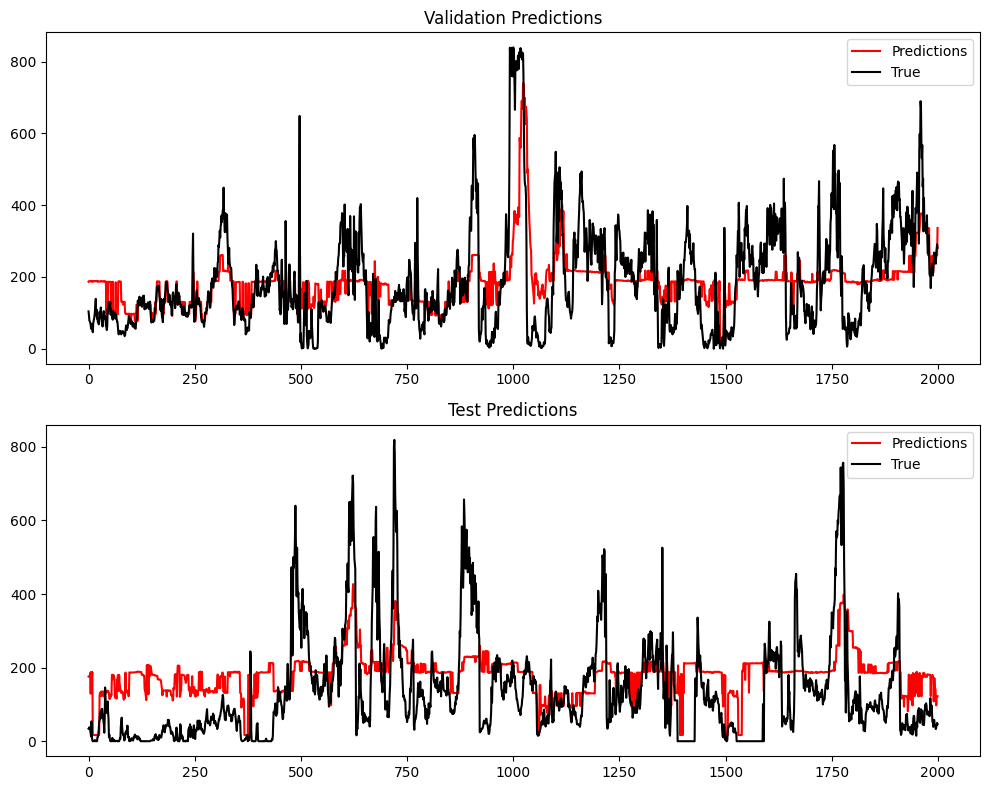

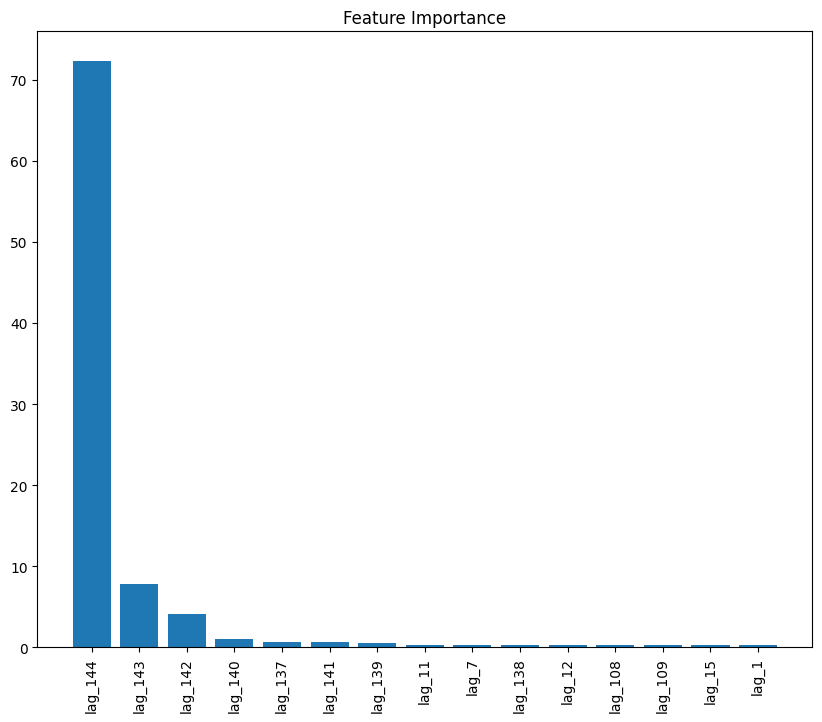

In [26]:
next_day_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=2000, feat_importance=True, feat_steps=15,feat_names= columns,horizon =144)

# Result Comparison

In [27]:
from tabulate import tabulate

results = [next_step_os.iloc[1,:],next_hour_os.iloc[1,:],next_day_os.iloc[1,:],
           next_hour_rec.iloc[1,:],next_day_rec.iloc[1,:]]

names = ['Next Step One Shot', 'Next Hour One Shot', 'Next Day One Shot',
         'Next Hour Recursive', 'Next Day Recursive']
metrics = ['MAE', 'RMSE', 'R2']

header = ['Metric'] + metrics
table_data = []

# Append MAE, RMSE, and R2 values for the test set

for i,n in enumerate(names):
  value = [n] + [results[i]['MAE']] + [results[i]['RMSE']]+ [results[i]['R2']]
  table_data.append(value)
table = tabulate(table_data, headers=header, tablefmt='pipe')

In [28]:
print(table)

| Metric              |      MAE |     RMSE |        R2 |
|:--------------------|---------:|---------:|----------:|
| Next Step One Shot  |  35.2638 |  54.0258 | 0.934019  |
| Next Hour One Shot  |  76.9393 | 108.67   | 0.733016  |
| Next Day One Shot   | 173.844  | 207.84   | 0.0179555 |
| Next Hour Recursive |  54.6697 |  76.5702 | 0.867453  |
| Next Day Recursive  | 119.604  | 149.643  | 0.494912  |
